In [1]:
from src.data_utils.base_datamodule import DataModule

from sklearn.datasets import fetch_openml
from types import SimpleNamespace
from typing import Tuple, List
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

class DiabetesDataModule(DataModule):
    def __init__(self
        ) -> None:
        super().__init__('diabetes')
    
    def load_data(self) -> Tuple[pd.DataFrame, pd.Series]:
        diabetes = fetch_openml(data_id = 37, data_home='./data_cache')

        data = diabetes.data
        
        le = LabelEncoder()
        label = pd.Series(le.fit_transform(diabetes.target))

        return data, label
    
    def prepare_data(self) -> Tuple[pd.DataFrame, pd.Series, List[str], List[str]]:

        data, label = self.load_data()

        categorical_cols = []
        
        numeric_cols = list(map(str, data.columns))
            
        return data, label.values, numeric_cols, categorical_cols

In [2]:
test_size = 0.2
random_seed = 42

In [3]:
from sklearn.model_selection import train_test_split

def prepare_data() -> Tuple[pd.DataFrame, np.array, pd.DataFrame, np.array]:
    datamodule = DiabetesDataModule()
    data, label, continuous_cols, categorical_cols = datamodule.prepare_data()

    train_idx, test_idx, _, _ = train_test_split(np.arange(len(label)).reshape((-1, 1)), label, test_size=test_size, random_state=random_seed, stratify=label)
    train_idx, test_idx = train_idx.ravel(), test_idx.ravel()

    X_test, y_test = data.iloc[test_idx], label[test_idx]
    data, label = data.iloc[train_idx], label[train_idx]
    
    return data, label, X_test, y_test, continuous_cols, categorical_cols

In [4]:
import importlib

def prepare_config(target_config: str) -> SimpleNamespace:
    configlib = importlib.import_module('src.config')
    config = getattr(configlib, target_config)
    
    config.model.out_dim = 2
    
    config.experiment.metric = "accuracy_score"
    config.experiment.metric_params = []
    config.experiment.data_config = "diabetes"
    config.experiment.optuna.direction = 'maximize'
    config.experiment.random_seed = random_seed
    config.experiment.task = "binary"
    
    config.experiment.optuna.n_trials = 1
    
    config.experiment.calibrator = "HistogramBinning"
    
    config.experiment.KFold = 1
    config.experiment.early_stopping_patience = 1
    config.dice.backend = "sklearn"
    
    config.experiment.fast_dev_run = True
    return config

In [5]:
data, label, X_test, y_test, continuous_cols, categorical_cols = prepare_data()
config = prepare_config('xgb_config')

/opt/conda/envs/jamia/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [6]:
from src.models import BaseModel
from src.misc.eval_metric import EvalMetric
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, recall_score, average_precision_score
from typing import Type

class DiabetesEvalMetric(EvalMetric):
    def eval(self, model: Type[BaseModel], X_test: pd.DataFrame, y_test: np.array):
        preds_proba = model.predict_proba(X_test)
        preds = preds_proba.argmax(1)
        
        f1 = f1_score(y_test, preds)
        roc = roc_auc_score(y_test, preds_proba[:, 1])
        specificity = recall_score(np.logical_not(y_test) , np.logical_not(preds))
        sensitivity = recall_score(y_test, preds)
        accuracy = accuracy_score(y_test, preds)
        pr_auc = average_precision_score(y_test, preds_proba[:, 1])
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        ppv = tp / (tp + fp)
        npv = tn / (tn + fn)
        
        print("F1 Score: %.4f" % f1)
        print("ROC AUC Score: %.4f" % roc)
        print("Specificity Score: %.4f" % specificity)
        print("Sensitivity Score: %.4f" % sensitivity)
        print("Accuracy Score: %.4f" % accuracy)
        print("Precision Recall AUC Score: %.4f" % pr_auc)
        print("PPV Score: %.4f" % ppv)
        print("NPV Score: %.4f" % npv)

        return {
            "F1 Score" : f1,
            "ROC AUC Score" : roc,
            "Specificity Score" : specificity,
            "Sensitivity Score" : sensitivity,
            "Accuracy Score" : accuracy,
            "Precision Recall AUC Score" : pr_auc,
            "PPV Score" : ppv,
            "NPV Score" : npv
        }

/opt/conda/envs/jamia/lib/python3.8/site-packages/pytorch_tabular/models/mixture_density/mdn.py:25: UserWarning: Wandb not installed. WandbLogger will not work.
  warnings.warn("Wandb not installed. WandbLogger will not work.")


In [7]:
from src.rias import RIAS
from src.models import XGB

rias = RIAS.prepare_rias(config, XGB, data, label, continuous_cols, categorical_cols, True)

rias.train()

rias.init_calibrator()
rias.test(X_test, y_test, DiabetesEvalMetric())

/opt/conda/envs/jamia/lib/python3.8/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "
2023-12-28 14:58:44.692257: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-28 14:58:45.284973: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[I 2023-12-28 14:58:45,818] A new study created in memory with name: no-name-c197a16d-b21e-41a7-972f-1bb635be1d08
[I 2023-12-28 14:58:46,191] Trial 0 finished with value: 0.6747967479674797 and parameters: {'max_leaves': 1686, 'n_estimators': 

Best Parameters
{'max_leaves': 1686, 'n_estimators': 2853, 'learning_rate': 0.7319939418114051, 'max_depth': 13, 'scale_pos_weight': 16}
Validation Score: 0.6748
Uncalibrated ECE : 0.23488494976446397
Calibrated ECE : 7.3337903049426e-17
Uncalibrated ECE : 0.23488494976446397
Calibrated ECE : 7.3337903049426e-17
F1 Score: 0.6466
ROC AUC Score: 0.7936
Specificity Score: 0.6400
Sensitivity Score: 0.7963
Accuracy Score: 0.6948
Precision Recall AUC Score: 0.6888
PPV Score: 0.5443
NPV Score: 0.8533


{'F1 Score': 0.6466165413533835,
 'ROC AUC Score': 0.7936111111111112,
 'Specificity Score': 0.64,
 'Sensitivity Score': 0.7962962962962963,
 'Accuracy Score': 0.6948051948051948,
 'Precision Recall AUC Score': 0.6887746728351708,
 'PPV Score': 0.5443037974683544,
 'NPV Score': 0.8533333333333334}

In [8]:
dice_d = X_test.iloc[:10].copy()

In [9]:
dice = rias.get_counterfactual_explanations(dice_d, features_to_vary=["preg", "insu", "mass"])

100%|██████████| 10/10 [00:01<00:00,  5.27it/s]

Query instance (original outcome : 1)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,7.0,159.0,64.0,0.0,0.0,27.4,0.294,40.0,1



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,12.9,159.0,64.0,0.0,0.0,42.8,0.294,40.0,0
1,12.2,159.0,64.0,0.0,0.0,42.5,0.294,40.0,0
2,7.0,159.0,64.0,0.0,0.0,43.2,0.294,40.0,0
3,7.0,159.0,64.0,0.0,425.5,57.6,0.294,40.0,0


Query instance (original outcome : 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,10.0,68.0,106.0,23.0,49.0,35.5,0.285,47.0,0



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,10.0,68.0,106.0,23.0,25.8,46.3,0.285,47.0,0
1,10.0,68.0,106.0,23.0,49.0,35.5,0.285,47.0,0
2,16.3,68.0,106.0,23.0,49.0,35.5,0.285,47.0,0
3,10.0,68.0,106.0,23.0,49.0,21.9,0.285,47.0,0


Query instance (original outcome : 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,2.0,122.0,76.0,27.0,200.0,35.900002,0.483,26.0,0



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,0.6,122.0,76.0,27.0,200.0,24.3,0.483,26.0,0
1,2.0,122.0,76.0,27.0,688.0,35.9,0.483,26.0,0
2,2.0,122.0,76.0,27.0,667.5,52.2,0.483,26.0,0
3,2.0,122.0,76.0,27.0,200.0,35.9,0.483,26.0,0


Query instance (original outcome : 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,7.0,114.0,64.0,0.0,0.0,27.4,0.732,34.0,0



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,4.3,114.0,64.0,0.0,0.0,21.5,0.732,34.0,0
1,7.0,114.0,64.0,0.0,454.8,11.2,0.732,34.0,0
2,7.0,114.0,64.0,0.0,0.0,24.3,0.732,34.0,0
3,7.0,114.0,64.0,0.0,0.0,59.9,0.732,34.0,0


Query instance (original outcome : 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,2.0,74.0,0.0,0.0,0.0,0.0,0.102,22.0,0



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,4.4,74.0,0.0,0.0,0.0,29.2,0.102,22.0,0
1,2.0,74.0,0.0,0.0,523.8,0.0,0.102,22.0,0
2,7.4,74.0,0.0,0.0,705.4,0.0,0.102,22.0,0
3,2.0,74.0,0.0,0.0,0.0,47.0,0.102,22.0,0


Query instance (original outcome : 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,3.0,100.0,68.0,23.0,81.0,31.6,0.949,28.0,0



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,3.0,100.0,68.0,23.0,81.0,31.6,0.949,28.0,0
1,3.0,100.0,68.0,23.0,81.0,14.5,0.949,28.0,0
2,13.2,100.0,68.0,23.0,81.0,31.6,0.949,28.0,0
3,3.0,100.0,68.0,23.0,81.0,0.6,0.949,28.0,0


Query instance (original outcome : 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,8.0,105.0,100.0,36.0,0.0,43.299999,0.239,45.0,0



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,2.5,105.0,100.0,36.0,0.0,43.3,0.239,45.0,0
1,8.0,105.0,100.0,36.0,229.7,43.3,0.239,45.0,0
2,8.0,105.0,100.0,36.0,0.0,34.5,0.239,45.0,0
3,5.4,105.0,100.0,36.0,0.0,5.9,0.239,45.0,0


Query instance (original outcome : 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,8.0,197.0,74.0,0.0,0.0,25.9,1.191,39.0,0



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,9.5,197.0,74.0,0.0,0.0,66.3,1.191,39.0,0
1,11.4,197.0,74.0,0.0,0.0,28.3,1.191,39.0,0
2,8.0,197.0,74.0,0.0,0.0,55.7,1.191,39.0,0
3,8.0,197.0,74.0,0.0,425.5,25.9,1.191,39.0,0


Query instance (original outcome : 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,2.0,100.0,64.0,23.0,0.0,29.700001,0.368,21.0,0



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,2.0,100.0,64.0,23.0,69.9,29.7,0.368,21.0,0
1,2.0,100.0,64.0,23.0,389.4,1.4,0.368,21.0,0
2,12.6,100.0,64.0,23.0,0.0,5.7,0.368,21.0,0
3,4.6,100.0,64.0,23.0,0.0,47.5,0.368,21.0,0


Query instance (original outcome : 1)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,0.0,165.0,76.0,43.0,255.0,47.900002,0.259,26.0,1



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,7.5,165.0,76.0,43.0,255.0,47.9,0.259,26.0,0
1,2.8,165.0,76.0,43.0,255.0,31.0,0.259,26.0,0
2,12.0,165.0,76.0,43.0,358.1,47.9,0.259,26.0,0
3,7.8,165.0,76.0,43.0,255.0,47.9,0.259,26.0,0


In [10]:
rias.init_shap_explainer()
rias.calculate_shap_values()

Permutation explainer: 615it [00:59,  8.93it/s]                         


In [11]:
rias.get_counterfactual_explanations(X_test.iloc[:3])

100%|██████████| 3/3 [00:00<00:00,  5.82it/s]

Query instance (original outcome : 1)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,7.0,159.0,64.0,0.0,0.0,27.4,0.294,40.0,1



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,7.0,159.0,64.0,0.0,0.0,27.4,0.622,40.0,0
1,7.0,159.0,64.0,0.0,632.8,27.4,0.294,68.6,0
2,7.0,159.0,64.0,0.0,98.4,27.4,0.294,71.4,0
3,7.0,159.0,64.0,0.0,0.0,27.4,1.648,40.0,0


Query instance (original outcome : 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,10.0,68.0,106.0,23.0,49.0,35.5,0.285,47.0,0



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,10.0,68.0,106.0,23.0,49.0,35.5,1.925,47.0,0
1,10.0,68.0,25.7,23.0,49.0,35.5,0.285,47.0,0
2,5.7,68.0,106.0,23.0,49.0,35.5,1.688,47.0,0
3,10.0,68.0,19.6,6.6,49.0,35.5,0.285,47.0,0


Query instance (original outcome : 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,2.0,122.0,76.0,27.0,200.0,35.900002,0.483,26.0,0



Diverse Counterfactual set (new outcome: 0)


,preg,plas,pres,skin,insu,mass,pedi,age,target
0,2.0,122.0,76.0,24.3,200.0,35.9,0.483,26.0,0
1,2.0,122.0,76.0,12.4,200.0,35.9,0.483,26.0,0
2,2.0,122.0,76.0,27.0,200.0,35.9,0.751,26.0,0
3,2.0,103.3,76.0,87.5,200.0,35.9,0.483,26.0,0


In [12]:
import shap
shap.initjs()

In [13]:
rias.save_rias()

loaded_name model
loaded_name model
loaded_name masker
loaded_name data
loaded_name max_samples
loaded_name clustering
loaded_name link


In [14]:
new_rias = RIAS.load_rias("diabetes-XGB-2023_10_16-23_55_36.pickle")

loaded_name model
loaded_name model
loaded_name masker
loaded_name data
loaded_name max_samples
loaded_name clustering
loaded_name link


In [15]:
shap.initjs()
new_rias.report_pred(X_test.iloc[0], 1)

Permutation explainer: 155it [00:13,  3.02it/s]                         


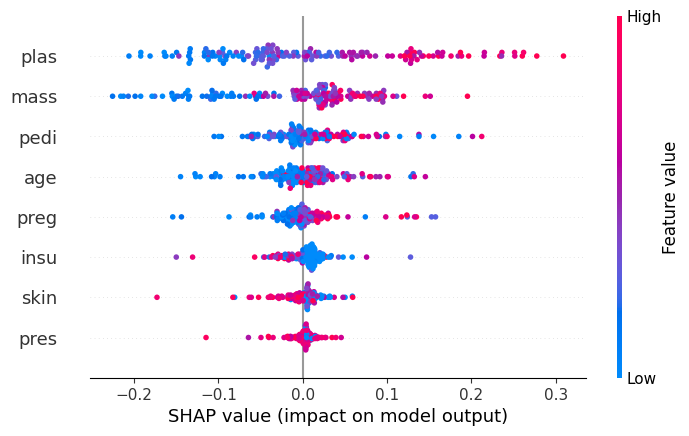

In [16]:
import shap
shap_values = rias.shap_explainer(X_test)
shap.plots.beeswarm(shap_values[:, :, 1])

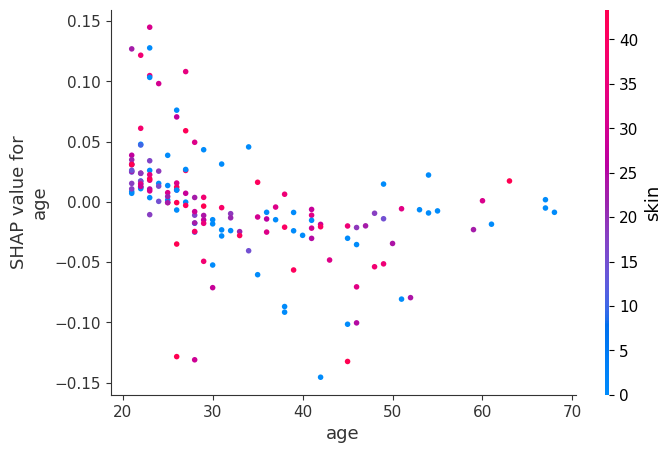

In [17]:
shap.dependence_plot("age", shap_values.values[:, :, 0], X_test, interaction_index=3)

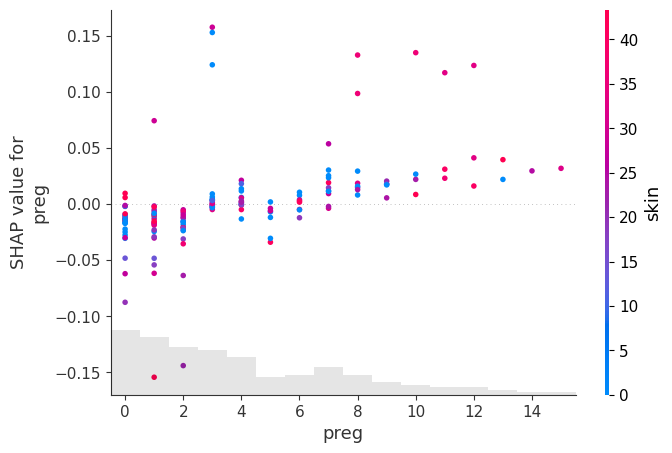

In [18]:
shap.plots.scatter(shap_values[:, "preg", 1], color=shap_values[:,:,1])